## Libraries

In [1]:
%load_ext autoreload
%autoreload 2.0
%matplotlib inline

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

/home/injy/mariam_workspace/env/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/injy/mariam_workspace/env/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/injy/mariam_workspace/env/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/injy/mariam_workspace/env/lib/python3.5/site-pack

In [3]:
import glob
# import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import numpy as np
import sys
sys.path.insert(0, '../.')
from data.segmentation_dataset_loader import *
from data.detection_dataset_loader import *
from model import *
from evaluation.evaluate import *
from data.postprocessing.nms import *
from data.data_utils.reader_utils import *

In [4]:
tf.__version__

'1.14.0'

## Utils

In [76]:
def sigmoid(x):
    x = x.astype(np.float128)
    x = 1 / (1 + np.exp(-x))
    x = x.astype(np.float32)
    return x

def convert_prediction_into_real_values(label_tensor, truth_value=None,
            anchors=np.array([3.9, 1.6, 1.5]), 
            input_size=(448, 512), output_size=(112, 128), is_label=False, th=0.5):

    ratio = input_size[0] // output_size[0]
    result = []
    ones_index = np.where(sigmoid(label_tensor[:, :,  -1])>=th)
    if truth_value is not None:
        ones_index = np.where(truth_value[:, :, -1]>=th)
    if len(ones_index) > 0 and len(ones_index[0]) > 0:
        for i in range(0, len(ones_index[0]), 1):
            x = ones_index[0][i]
            y = ones_index[1][i]
            
#             print('x = ', x, "y = ", y)
            
            out = np.copy(label_tensor[ones_index[0][i], ones_index[1][i], :])
            anchor = np.array([x, y, 0., anchors[0], anchors[1], anchors[2]])

            mins = np.array([-0.5, -0.5, 0, 0.7, 0.1, 0.1, -1.1, -1.1])
            maxs = np.array([0.5, 0.5, 1, 1.9, 0.75, 0.91, 1.1, 1.1])
        
            out[:8] = ((out[:8] + 1) / 2) * (maxs - mins) + mins
#             out[:2] = out[:2][::-1]
#             if truth_value is not None:
#                 print('gt = ', truth_value[ones_index[0][i], ones_index[1][i], :3])
#             print('out[:3] = ', out[:3])
            out[:3] = np.exp(out[:3])
#             print('exp(out[:3]) = ', out[:3])
    
            out[:3] = out[:3] + anchor[:3]
#             print('out[:3] anch = ', out[:3])
            
            out[:2] = out[:2] * ratio
            out[2] = out[2] * 35
            
#             print('final out[:3] = ', out[:3])
            
            
            
#             out[6] = np.arctan2(out[6], out[7])
                        
            result.append(out)
            
    return np.array(result)

In [6]:
import numpy as np
from PIL import Image, ImageDraw
import math
import numpy.matlib as npm

def convert5Pointto8Point(cx_, cy_, w_, h_, a_):

    theta = math.radians(a_)
    bbox = npm.repmat([[cx_], [cy_]], 1, 5) + \
       np.matmul([[math.cos(theta), math.sin(theta)],
                  [-math.sin(theta), math.cos(theta)]],
                 [[-w_ / 2, w_/ 2, w_ / 2, -w_ / 2, w_ / 2 + 8],
                  [-h_ / 2, -h_ / 2, h_ / 2, h_ / 2, 0]])
    x1, y1 = bbox[0][0], bbox[1][0]
    x2, y2 = bbox[0][1], bbox[1][1]
    x3, y3 = bbox[0][2], bbox[1][2]
    x4, y4 = bbox[0][3], bbox[1][3]

    return [x1, y1, x2, y2, x3, y3, x4, y4]

In [7]:
def get_points(converted_points, calib_path, 
                x_range=(0, 70), y_range=(-40, 40), z_range=(-2.5, 1), 
                size=(448, 512, 35), th=0.5):
    all_result = []
    for converted_points_ in converted_points:
        if sigmoid(converted_points_[-1]) >= th:
            result = [0] * 16
            result[0] = 'Car'
            result[1] = -1
            result[2] = -1
            result[3] = -10
            result[8] = converted_points_[5]
            result[9] = converted_points_[4]
            result[10] = converted_points_[3]
            result[14] = np.arctan2(converted_points_[6], converted_points_[7])
            result[15] = sigmoid(converted_points_[-1])

            calib_data = read_calib(calib_path)

            x_size = (x_range[1] - x_range[0])
            y_size = (y_range[1] - y_range[0])
            z_size = (z_range[1] - z_range[0])

            x_fac = (size[0]-1) / x_size
            y_fac = (size[1]-1) / y_size
            z_fac = (size[2]-1) / z_size          

#             print(converted_points_[:3])
#             converted_points_[0] = 179.55859811597736
#             converted_points_[1] = 276.6431893013815
#             , 206.281385562958]
#             print(converted_points_[:3])
            x, y, z = -((converted_points_[:3] - size) / np.array([x_fac, y_fac, z_fac])) - np.array([0, -1*y_range[0], -1*z_range[0]]) 
            point = np.array([[x, y, z]])
#             print('point')
#             print(point)
            box3d_pts_3d = point

            pts_3d_ref = project_velo_to_ref(box3d_pts_3d, calib_data['Tr_velo_to_cam'].reshape((3, 4)))
#             print('pts_3d_ref')
#             print(pts_3d_ref)
            pts_3d_ref = project_ref_to_rect(pts_3d_ref, calib_data['R0_rect'].reshape((3, 3)))[0]
#             print('pts_3d_ref')
#             print(pts_3d_ref)
            for k in range(3):
                result[11 + k] = pts_3d_ref[k]

            imgbbox = ProjectTo2Dbbox(pts_3d_ref, converted_points_[5], converted_points_[4],
                         converted_points_[3], converted_points_[6], calib_data['P2'].reshape((3, 4)))

            result[4:8] = imgbbox
            all_result.append(result)
    return all_result

## Evaluation

In [11]:
def read_label(rot, tr, sc, label_path, calib_path, shift_h, shift_w, x_range=(0, 70), y_range=(-40, 40), z_range=(-2.5, 1), 
                    size=(448, 512, 35), get_actual_dims=False, from_file=True, translate_x=0, translate_y=0, translate_z=0, ang=0, get_neg=False, fliplr=False):

    """
    the file format is as follows: 
    type, truncated, occluded, alpha, bbox_left, bbox_top, bbox_right, bbox_bottom,
    dimensions_height, dimensions_width, dimensions_length, location_x, location_y, location_z,
    rotation_y, score) 
    """
    if from_file:
        lines = []
        with open(label_path) as label_file:
            lines = label_file.readlines()
    else:
        lines = label_path.split('\n')
    # filter car class
    lines = list(map(lambda x: x.split(), lines))
    if len(lines) > 0:
        if get_neg:
            # lines = list(filter(lambda x: len(x) > 0 and ( x[0] not in ['Car', 'Van', 'Truck', 'Tram', 'DontCare']), lines))
            lines = list(filter(lambda x: len(x) > 0 and ( x[0] not in ['Car']), lines))
            if len(lines) > 0:
                lines = lines[:1]
        else:
            # lines = list(filter(lambda x: len(x) > 0 and ( x[0] in ['Car', 'Van', 'Truck', 'Tram']), lines))
             lines = list(filter(lambda x: len(x) > 0 and ( x[0] in ['Car']), lines))
    
    def get_parameter(index):
        return list(map(lambda x: x[index], lines))
    
    classes = np.array(get_parameter(0))
    dimension_height = np.array(get_parameter(8)).astype(float)
    dimension_width = np.array(get_parameter(9)).astype(float)
    dimension_length = np.array(get_parameter(10)).astype(float)
    # TODO: take shift into consideration - URGENT
    location_x = np.array(get_parameter(11)).astype(float)
    location_y = np.array(get_parameter(12)).astype(float)
    location_z = np.array(get_parameter(13)).astype(float)
    angles = np.array(get_parameter(14)).astype(float)
    directions = np.array(angles>= 0).astype(float)
    
    # print(len(classes))
    calib_data = read_calib(calib_path)

    locations = np.array([[location_x[i], location_y[i], location_z[i]] for i in range(len(classes))])
    # print(locations.shape)
    # print(locations)
    if len(locations) > 0 and len(locations[0]) > 0:
        locations = project_rect_to_velo2(rot, tr, sc, locations, calib_data['R0_rect'].reshape((3, 3)), calib_data['Tr_velo_to_cam'].reshape((3, 4)))
    # if len(locations) > 0 and len(locations[0]) > 0:
    #     locations = project_rect_to_velo(locations, calib_data['R0_rect'].reshape((3, 3)), calib_data['Tr_velo_to_cam'].reshape((3, 4)))
    # print(locations.shape)
    # print(z_range)
    # print(locations)

    indx = []
    i = 0
    for point in locations:
        if (point[0] >= x_range[0]  and point[0] <= x_range[1])\
            and (point[1] >= y_range[0] and point[1] <= y_range[1])\
            and (point[2] >= z_range[0] and point[2] <= z_range[1]):
            indx.append(i)
        i += 1

    
    locations = np.array(list(filter(lambda point: (point[0] >= x_range[0]  and point[0] <= x_range[1])
                                    and (point[1] >= y_range[0] and point[1] <= y_range[1])
                                    and (point[2] >= z_range[0] and point[2] <= z_range[1]) , locations)))
    
    if len(indx) > 0:
        dimension_height = dimension_height[indx]
        dimension_width = dimension_width[indx]
        dimension_length = dimension_length[indx]
        location_x = location_x[indx]
        location_y = location_y[indx]
        location_z = location_z[indx]
        angles = angles[indx]
        classes = classes[indx]
        directions = directions[indx]

    points = [project_point_from_camera_coor_to_velo_coor2(rot, tr, sc, [location_x[i], location_y[i], location_z[i]], 
                                                        [dimension_height[i], dimension_width[i], dimension_length[i]],
                                                        angles[i],
                                                         calib_data)
                for i in range(len(locations))]
    # points = [project_point_from_camera_coor_to_velo_coor([location_x[i], location_y[i], location_z[i]], 
    #                                                     [dimension_height[i], dimension_width[i], dimension_length[i]],
    #                                                     angles[i],
    #                                                      calib_data)
    #             for i in range(len(locations))]
    
    x_size = (x_range[1] - x_range[0])
    y_size = (y_range[1] - y_range[0])
    z_size = (z_range[1] - z_range[0])
            
    x_fac = (size[0]-1) / x_size
    y_fac = (size[1]-1) / y_size
    z_fac = (size[2]-1) / z_size

    if get_actual_dims:
        import math
        for i in range(len(points)):
            b = points[i]
            x0 = b[0][0]
            y0 = b[0][1]
            x1 = b[1][0]
            y1 = b[1][1]
            x2 = b[2][0]
            y2 = b[2][1]
            u0 = -(x0) * x_fac + size[0]
            v0 = -(y0 + 35) * y_fac + size[1]
            u1 = -(x1) * x_fac + size[0]
            v1 = -(y1 + 35) * y_fac + size[1]
            u2 = -(x2) * x_fac + size[0]
            v2 = -(y2 + 35) * y_fac + size[1]
            dimension_length[i] = math.sqrt((v1-v2)**2 + (u1-u2)**2)
            dimension_width[i] = math.sqrt((v1-v0)**2 + (u1-u0)**2)
            dimension_height[i] = math.sqrt((-(b[0][2]+(-1*z_range[1]))*z_fac-(-b[4][2]+z_range[1])*z_fac)**2)

      
#     for i in range(len(locations)):
#         if angles[i] < 0:
#             angles[i] += 3.14

    x_range = (x_range[0] + translate_x, x_range[1] + translate_x)
    y_range = (y_range[0] + translate_y, y_range[1] + translate_y)
    z_range = (z_range[0] + translate_z, z_range[1] + translate_z)
    output = [[-(locations[i][0] + -1*x_range[0]) * x_fac + size[0], -(locations[i][1] + -1*y_range[0]) * y_fac + size[1], -(locations[i][2] + -1*z_range[0]) * z_fac + size[2], 
                dimension_length[i], dimension_width[i], dimension_height[i], angles[i]] 
                for i in range(len(locations))]
    # output = [[locations[i][0], locations[i][1], locations[i][2], 
    #             dimension_length[i], dimension_width[i], dimension_height[i], angles[i]] 
    #             for i in range(len(locations))]
    # import math
    if fliplr:
        for i in range(len(locations)):
            h = size[1]
            output[i][1] = h - output[i][1]

    if ang != 0:
        for i in range(len(locations)):
            # w = size[0]
            # h = size[1]
            # output[i][0], output[i][1] = rotate2((w//2, h//2), (output[i][0], output[i][1]), ang / 57.2958)
            output[i][6] = output[i][6] - ang / 57.2958

    output = list(filter(lambda point: 0 <= point[0] < size[0] and 0 <= point[1] < size[1] and 0 <= point[2] < size[2] , output))
    output = np.array(output)

    return points, output, calib_data['Tr_velo_to_cam'], calib_data['R0_rect'], calib_data['P2'], directions


In [58]:
def read_label2(label_path, calib_path, shift_h, shift_w, x_range=(0, 70), y_range=(-40, 40), z_range=(-2.5, 1), 
                    size=(448, 512, 35), get_actual_dims=False, from_file=True, translate_x=0, translate_y=0, translate_z=0, ang=0, get_neg=False):

    """
    the file format is as follows: 
    type, truncated, occluded, alpha, bbox_left, bbox_top, bbox_right, bbox_bottom,
    dimensions_height, dimensions_width, dimensions_length, location_x, location_y, location_z,
    rotation_y, score) 
    """
    if from_file:
        lines = []
        with open(label_path, 'r') as label_file:
            lines = label_file.readlines()
    else:
        lines = label_path.split('\n')
    # filter car class
    lines = list(map(lambda x: x.split(), lines))
    if len(lines) > 0:
        if get_neg:
            lines = list(filter(lambda x: len(x) > 0 and ( x[0] not in ['Car', 'Van', 'Truck', 'Tram', 'DontCare']), lines))
            if len(lines) > 0:
                lines = lines[:1]
        else:
            lines = list(filter(lambda x: len(x) > 0 and ( x[0] in ['Car']), lines))
    
    def get_parameter(index):
        return list(map(lambda x: x[index], lines))
    
    classes = np.array(get_parameter(0))
    dimension_height = np.array(get_parameter(8)).astype(float)
    dimension_width = np.array(get_parameter(9)).astype(float)
    dimension_length = np.array(get_parameter(10)).astype(float)
    # TODO: take shift into consideration - URGENT
    location_x = np.array(get_parameter(11)).astype(float)
    location_y = np.array(get_parameter(12)).astype(float)
    location_z = np.array(get_parameter(13)).astype(float)
    angles = np.array(get_parameter(14)).astype(float)
    
    # print(len(classes))
    calib_data = read_calib(calib_path)

    locations = np.array([[location_x[i], location_y[i], location_z[i]] for i in range(len(classes))])
    # print(locations)
    if len(locations) > 0 and len(locations[0]) > 0:
        locations = project_rect_to_velo(locations, calib_data['R0_rect'].reshape((3, 3)), calib_data['Tr_velo_to_cam'].reshape((3, 4)))
    # print(locations)
    # print(z_range)
    locations = np.array(list(filter(lambda point: (point[0] >= x_range[0]  and point[0] <= x_range[1])
                                    and (point[1] >= y_range[0] and point[1] <= y_range[1])
                                    and (point[2] >= z_range[0] and point[2] <= z_range[1]) , locations)))

    indx = []
    i = 0
    for point in locations:
        if (point[0] >= x_range[0]  and point[0] <= x_range[1])\
            and (point[1] >= y_range[0] and point[1] <= y_range[1])\
            and (point[2] >= z_range[0] and point[2] <= z_range[1]):
            indx.append(i)
        i += 1

    if len(indx) > 0:
        dimension_height = dimension_height[indx]
        dimension_width = dimension_width[indx]
        dimension_length = dimension_length[indx]
        location_x = location_x[indx]
        location_y = location_y[indx]
        location_z = location_z[indx]
        angles = angles[indx]
        classes = classes[indx]

    if len(locations) > 0:
        locations[:, :3] = locations[:, :3] - np.array([translate_x, translate_y, -translate_z])

    # print('.......')
    # print(len(locations))

    points = [project_point_from_camera_coor_to_velo_coor([location_x[i], location_y[i], location_z[i]], 
                                                        [dimension_height[i], dimension_width[i], dimension_length[i]],
                                                        angles[i],
                                                         calib_data)
                for i in range(len(locations))]
    
    x_size = (x_range[1] - x_range[0])
    y_size = (y_range[1] - y_range[0])
    z_size = (z_range[1] - z_range[0])
            
    x_fac = (size[0]-1) / x_size
    y_fac = (size[1]-1) / y_size
    z_fac = (size[2]-1) / z_size
    if get_actual_dims:
        import math
        for i in range(len(points)):
            b = points[i]
            x0 = b[0][0]
            y0 = b[0][1]
            x1 = b[1][0]
            y1 = b[1][1]
            x2 = b[2][0]
            y2 = b[2][1]
            u0 = -(x0) * x_fac + size[0]
            v0 = -(y0 + 35) * y_fac + size[1]
            u1 = -(x1) * x_fac + size[0]
            v1 = -(y1 + 35) * y_fac + size[1]
            u2 = -(x2) * x_fac + size[0]
            v2 = -(y2 + 35) * y_fac + size[1]
            dimension_length[i] = math.sqrt((v1-v2)**2 + (u1-u2)**2)
            dimension_width[i] = math.sqrt((v1-v0)**2 + (u1-u0)**2)
            dimension_height[i] = math.sqrt((-(b[0][2]+(-1*z_range[1]))*z_fac-(-b[4][2]+z_range[1])*z_fac)**2)

      
#     for i in range(len(locations)):
#             if angles[i] < 0:
#                 angles[i] += np.pi

    x_range = (x_range[0] + translate_x, x_range[1] + translate_x)
    y_range = (y_range[0] + translate_y, y_range[1] + translate_y)
    z_range = (z_range[0] + translate_z, z_range[1] + translate_z)
    output = [[-(locations[i][0] + -1*x_range[0]) * x_fac + size[0], -(locations[i][1] + -1*y_range[0]) * y_fac + size[1], -(locations[i][2] + -1*z_range[0]) * z_fac + size[2], 
                dimension_height[i], dimension_width[i], dimension_length[i], angles[i]] 
                for i in range(len(locations))]
    # import math
    if ang != 0:
        for i in range(len(locations)):
            w = size[0]
            h = size[1]
            output[i][0], output[i][1] = rotate2((w//2, h//2), (output[i][0], output[i][1]), ang / 57.2958)
            output[i][6] = output[i][6] - ang / 57.2958

    output = list(filter(lambda point: 0 <= point[0] < size[0] and 0 <= point[1] < size[1] and 0 <= point[2] < size[2] , output))
    output = np.array(output)

    return points, output, calib_data['Tr_velo_to_cam'], calib_data['R0_rect'], calib_data['P2']




In [59]:
base_path = '../../../Data'

In [60]:
def get_augmentation_parameters(augment):
        # if self.augment:
        if augment:

                    if np.random.random_sample() >= 0.0:
                        image_translate_x = random.randint(-50, 50)
                    else:
                        image_translate_x = 0
                    if np.random.random_sample() >= 0.0:
                        image_translate_y = random.randint(-25, 25)
                    else:
                        image_translate_y = 0

                    if np.random.random_sample() >= 0.0:
                        translate_x = np.random.random_sample() * 40 - 20
                    else:
                        translate_x = 0
                    if np.random.random_sample() >= 0.0:
                        # translate_y = random.randint(-15, 15)
                        translate_y = np.random.random_sample() * 40 - 20
                    else:
                        translate_y = 0

                    if np.random.random_sample() >= 0.0:
                        translate_z = random.random() - 0.5
                    else:
                        translate_z = 0

                    if np.random.random_sample() >= 0.0:
                        ang = np.random.random_sample() * 90 - 45
                    else:
                        ang = 0

                    r = R.from_rotvec(np.radians(ang) * np.array([0, 0, 1]))
                    rot = r.as_dcm()
                    rot = np.append(rot, np.array([[0,0,0]]), axis=0)
                    rot = np.append(rot, np.array([[0],[0],[0],[1]]), axis=1)

                    tr_x = translate_x
                    tr_y = translate_y
                    tr_z = translate_z
                    tr = np.array([[tr_x], [tr_y], [tr_z], [0]])
                    
                    translate_x = 0
                    translate_y = 0
                    translate_z = 0
                    
                    sc_x = 1
                    sc_y = 1
                    sc_z = 1   

                    if np.random.random_sample() >= 0.0:
                       sc_x += ((random.random() * 2) - 1.) / 10.

                    if np.random.random_sample() >= 0.0:
                       sc_y  += ((random.random() * 2) - 1.) / 10.
                    

                    sc = np.array([[sc_x, 0, 0, 0], [0, sc_y, 0, 0], [0, 0, sc_z, 0], [0, 0, 0, 1]])

                    fliplr = np.random.random_sample() >= 0.5

        else:
                    image_translate_x = 0
                    image_translate_y = 0

                    translate_x = 0
                    translate_y = 0
                    translate_z = 0
                    ang = 0

                    r = R.from_rotvec(np.radians(0) * np.array([0, 0, 1]))
                    rot = r.as_dcm()
                    rot = np.append(rot, np.array([[0,0,0]]), axis=0)
                    rot = np.append(rot, np.array([[0],[0],[0],[1]]), axis=1)

                    tr_x = 0
                    tr_y = 0
                    tr_z = 0
                    tr = np.array([[tr_x], [tr_y], [tr_z], [0]])

                    sc_x = 1
                    sc_y = 1
                    sc_z = 1
                    sc = np.array([[sc_x, 0, 0, 0], [0, sc_y, 0, 0], [0, 0, sc_z, 0], [0, 0, 0, 1]])

                    fliplr = False

        return rot, tr, sc, image_translate_x, image_translate_y, ang, fliplr

In [61]:
def data_generator(base_path, i, list_camera_paths, list_lidar_paths, list_label_paths, list_calib_paths, 
                   image_size=(370, 1224), lidar_size=(700, 800, 35), anchors=np.array([3.9, 1.6, 1.5]),
                        augment_translate=False, augment_rotate=False):

                rot, tr, sc, image_translate_x, image_translate_y, ang, fliplr = get_augmentation_parameters(False)

                data_reader_obj = DataReader(list_camera_paths[i],
                             list_calib_paths[i], 
                             list_label_paths[i], 
                             list_lidar_paths[i], 
                             rot, sc, tr, ang, image_translate_x, image_translate_y, get_actual_dims=False, fliplr=fliplr)
                camera_image = data_reader_obj.read_image()
                lidar_image = data_reader_obj.lidar_reader.read_lidar()
                _, label, directions = data_reader_obj.label_reader.read_label()
            
                label = get_target(label, directions, anchors=anchors)
              
                yield(camera_image, lidar_image, label)

In [16]:
params = {
    'fusion': False
}
model = Model(graph=None, **params)

/home/injy/mariam_workspace/env/lib/python3.5/site-packages/torch/hub.py:411: UserWarning: TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead
  warnings.warn('TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead')


Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where











In [62]:
def read_label2(label_path, calib_path, shift_h, shift_w, x_range=(0, 70), y_range=(-40, 40), z_range=(-2.5, 1), 
                    size=(448, 512, 35), get_actual_dims=False, from_file=True, translate_x=0, translate_y=0, ang=0, get_neg=False):
#     return __read_label(label_path, calib_path, shift_h, shift_w, x_range=x_range, y_range=y_range, z_range=z_range, 
#                     size=size, get_actual_dims=get_actual_dims, from_file=from_file, translate_x=translate_x, translate_y=translate_y, ang=ang, get_neg=get_neg)



# def __read_label(label_path, calib_path, shift_h, shift_w, x_range=(0, 71), y_range=(-40, 40), z_range=(-3.0, 1), 
#                     size=(512, 448, 32), get_actual_dims=False, from_file=True, translate_x=0, translate_y=0, ang=0,
#                     get_neg=False):
    """
    the file format is as follows: 
    type, truncated, occluded, alpha, bbox_left, bbox_top, bbox_right, bbox_bottom,
    dimensions_height, dimensions_width, dimensions_length, location_x, location_y, location_z,
    rotation_y, score) 
    """
    if from_file:
        lines = []
        with open(label_path) as label_file:
            lines = label_file.readlines()
    else:
        lines = label_path.split('\n')
    # filter car class
    lines = list(map(lambda x: x.split(), lines))
#     print('lines', len(lines))
    if len(lines) > 0:
        if get_neg:
            lines = list(filter(lambda x: len(x) > 0 and ( x[0] not in ['Car', 'Van', 'Truck', 'Tram', 'DontCare']), lines))
            if len(lines) > 0:
                lines = lines[:1]
        else:
            lines = list(filter(lambda x: len(x) > 0 and ( x[0] in ['Car']), lines))
#             print(len(lines))
    
    def get_parameter(index):
        return list(map(lambda x: x[index], lines))
    
    classes = get_parameter(0)
    dimension_height = np.array(get_parameter(8)).astype(float)
    dimension_width = np.array(get_parameter(9)).astype(float)
    dimension_length = np.array(get_parameter(10)).astype(float)
    # TODO: take shift into consideration - URGENT
    location_x = np.array(get_parameter(11)).astype(float)
    location_y = np.array(get_parameter(12)).astype(float)
    location_z = np.array(get_parameter(13)).astype(float)
    angles = np.array(get_parameter(14)).astype(float)
    
    # print(len(classes))
    calib_data = read_calib(calib_path)

    locations = np.array([[location_x[i], location_y[i], location_z[i]] for i in range(len(classes))])
#     print('locations', len(locations))
    if len(locations) > 0 and len(locations[0]) > 0:
        locations = project_rect_to_velo(locations, calib_data['R0_rect'].reshape((3, 3)), calib_data['Tr_velo_to_cam'].reshape((3, 4)))
#     print('locations', len(locations))
    # print(z_range)
    indxes = np.array(list(map(lambda point: (point[0] >= x_range[0]  and point[0] <= x_range[1])
                                    and (point[1] >= y_range[0] and point[1] <= y_range[1])
                                    and (point[2] >= z_range[0] and point[2] <= z_range[1]) , locations)))
#     print("indxes", len(indxes[indxes==True]))
#     print("indxes", indxes)
#     print(locations)
    locations = np.array(list(filter(lambda point: (point[0] >= x_range[0]  and point[0] <= x_range[1])
                                    and (point[1] >= y_range[0] and point[1] <= y_range[1])
                                    and (point[2] >= z_range[0] and point[2] <= z_range[1]) , locations)))

#     print(locations)
#     print('locations', len(locations))
    if len(locations) > 0:
        locations[:, :2] = locations[:, :2] - np.array([translate_x, translate_y])

    # print('.......')
    

    points = [project_point_from_camera_coor_to_velo_coor([location_x[i], location_y[i], location_z[i]], 
                                                        [dimension_height[i], dimension_width[i], dimension_length[i]],
                                                        angles[i],
                                                         calib_data)
                for i in range(len(locations))]
    
    x_size = (x_range[1] - x_range[0])
    y_size = (y_range[1] - y_range[0])
    z_size = (z_range[1] - z_range[0])
            
    x_fac = (size[0]-1) / x_size
    y_fac = (size[1]-1) / y_size
    z_fac = (size[2]-1) / z_size
    if get_actual_dims:
        import math
        for i in range(len(points)):
            b = points[i]
            x0 = b[0][0]
            y0 = b[0][1]
            x1 = b[1][0]
            y1 = b[1][1]
            x2 = b[2][0]
            y2 = b[2][1]
            u0 = -(x0) * x_fac + size[0]
            v0 = -(y0 + 35) * y_fac + size[1]
            u1 = -(x1) * x_fac + size[0]
            v1 = -(y1 + 35) * y_fac + size[1]
            u2 = -(x2) * x_fac + size[0]
            v2 = -(y2 + 35) * y_fac + size[1]
            # print(dimension_length[i])
            dimension_length[i] = math.sqrt((v1-v2)**2 + (u1-u2)**2)
            # print(dimension_length[i])
            dimension_width[i] = math.sqrt((v1-v0)**2 + (u1-u0)**2)
            # print(dimension_height[i])
            dimension_height[i] = math.sqrt((-(b[0][2]+(-1*z_range[1]))*z_fac-(-b[4][2]+z_range[1])*z_fac)**2)
            # print(dimension_height[i])

      


    x_range = (x_range[0] + translate_x, x_range[1] + translate_x)
    y_range = (y_range[0] + translate_y, y_range[1] + translate_y)
    output = [[-(locations[i][0]) * x_fac + size[0], -(locations[i][1] + -1*y_range[0]) * y_fac + size[1], -(locations[i][2] + -1*z_range[0]) * z_fac + size[2], 
                dimension_length[i], dimension_width[i], dimension_height[i], angles[i]] 
                for i in range(len(locations))]
    
#     for i in range(len(locations)):
#             if angles[i] < 0:
#                 angles[i] += np.pi
        
    # import math
    if ang != 0:
        for i in range(len(locations)):
            w = size[0]
            h = size[1]
            output[i][0], output[i][1] = rotate2((w//2, h//2), (output[i][0], output[i][1]), ang / 57.2958)
            output[i][6] = output[i][6] - ang / 57.2958

    output = np.array(output)
    if from_file:
        return points, output, calib_data['Tr_velo_to_cam'], calib_data['R0_rect'], calib_data['P2']
    else:
        return output, indxes




In [63]:
def prepare_dataset_feed_dict_2(model, dataset, train_fusion_rgb, is_training=False):
        data = list(next(dataset))

        for i in range(len(data)):
            data[i] = np.expand_dims(data[i], axis=0)
        camera_tensor, lidar_tensor, label_tensor = data
        d = {model.train_inputs_rgb: camera_tensor,
                model.train_inputs_lidar: lidar_tensor,
                model.y_true: label_tensor,
                model.train_fusion_rgb: train_fusion_rgb,
                model.is_training: False}
        return d

In [64]:
training=False

In [65]:
if training:
                file_name = '/trainsplit.txt'
else:
                file_name = '/valsplit.txt'
with open(base_path + file_name, 'r') as f:
                list_file_nums = f.readlines()
list_files = ['0'*(6-len(l.strip())) + l.strip() for l in list_file_nums]

list_camera_paths = list(map(lambda x: base_path+'/data_object_image_3/training/image_3/' + x + '.png', list_files))
list_lidar_paths = list(map(lambda x: base_path+'/data_object_velodyne/training/velodyne/' + x + '.bin', list_files))
list_label_paths = list(map(lambda x: base_path + '/data_object_label_2/training/label_2/' + x + '.txt', list_files))
list_calib_paths = list(map(lambda x: base_path + '/data_object_calib/training/calib/' + x + '.txt', list_files))

In [200]:
i_c = 23
current_file = list_files[i_c]
current_file

'000045'

In [201]:
t = base_path + '/data_object_label_2/training/label_2/'+ current_file + '.txt'
!cat $t

Car 0.00 0 2.12 75.43 192.52 273.65 277.52 1.47 1.63 4.11 -8.95 1.92 15.21 1.59
Tram 0.00 0 -1.65 694.04 152.62 734.19 188.24 3.33 2.37 23.29 11.16 1.55 79.53 -1.51
Car 0.00 0 1.98 269.01 176.97 375.72 242.36 1.80 1.61 3.83 -8.66 1.94 21.96 1.60
Car 0.00 1 1.95 346.60 186.70 419.98 229.04 1.45 1.45 3.40 -8.46 1.99 27.06 1.65
Car 0.00 1 1.87 387.31 178.52 455.56 221.43 1.75 1.71 4.31 -8.27 2.02 31.88 1.61
Car 0.00 0 1.80 455.95 181.43 500.99 209.72 1.53 1.66 4.01 -7.54 2.03 41.53 1.62
Car 0.00 2 1.79 480.03 181.40 517.92 205.67 1.48 1.60 3.90 -7.16 2.05 46.70 1.64
DontCare -1 -1 -10 532.46 177.22 558.68 194.04 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 654.37 171.38 663.83 177.60 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 642.14 171.49 649.84 176.74 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 759.56 166.69 772.10 186.52 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 814.77 163.56 832.52 193.81 -1 -1 -1 -1000 -1000 -1000 -10


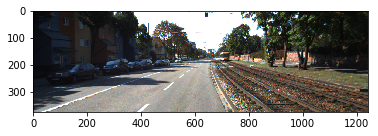

In [202]:
img = mpimg.imread(base_path + '/data_object_image_3/training/image_3/' +current_file+".png")
plt.imshow(img)

In [256]:
with model.graph.as_default():
    
            
  config = tf.ConfigProto()
  config.gpu_options.allow_growth = True

  with tf.Session(config=config) as sess:
    model.saver.restore(sess, tf.train.latest_checkpoint('../training_files/tmp/'))
#     model.saver.restore(sess, tf.train.latest_checkpoint('../training_files_archive/training_files/tmp/'))
#     model.saver.restore(sess, tf.train.latest_checkpoint('../training_files_to_resume/tmp/'))
#     model.saver.restore(sess, tf.train.latest_checkpoint('../training_files_archive/training_files_3/tmp/'))
    dataset = data_generator(base_path, i_c, list_camera_paths, list_lidar_paths, list_label_paths, list_calib_paths)
   
    i = 0
    if True:

      feed_dict = prepare_dataset_feed_dict_2(model, dataset, False)
      feed_dict[model.weight_cls] = 1
      feed_dict[model.weight_loc] = 1
      feed_dict[model.weight_dim] = 1
      feed_dict[model.weight_theta] = 1
   

      final_output, cls_loss, loc_loss, dim_loss, theta_loss,\
                        reg_loss, iou, iou_2d, iou_dim, iou_loc,\
                        precision, recall, theta_accuracy,\
                    debug_layers, cnn_lidar_resgroups= sess.run([model.final_output,\
                                                              model.classification_loss, model.loc_reg_loss, model.dim_reg_loss, model.theta_reg_loss,\
                                                              model.regression_loss,\
                                                             model.iou, model.iou_2d, model.iou_dim, model.iou_loc,\
                                                             model.precision, model.recall,\
                                                              model.theta_accuracy, model.debug_layers, model.cnn_lidar.res_groups2 ],\
                                                             feed_dict=feed_dict) 

INFO:tensorflow:Restoring parameters from ../training_files/tmp/model.ckpt-5523


In [258]:
cls_loss, loc_loss, dim_loss, theta_loss, theta_accuracy, reg_loss, iou, iou_2d, iou_dim, iou_loc, precision, recall

(0.9914503,
 0.04024261,
 0.03349912,
 0.016348379,
 3.8958805,
 0.7701141,
 0.80850697,
 0.8691404,
 0.88990074,
 0.8489712,
 1.0,
 0.33333334)

In [205]:
cls_loss, loc_loss, dim_loss, theta_loss, theta_accuracy, reg_loss, iou, iou_2d, iou_dim, iou_loc, precision, recall

(1.0143085,
 0.052766338,
 0.027814882,
 0.015578318,
 4.1346397,
 0.83696884,
 0.82533425,
 0.884698,
 0.8998647,
 0.8662996,
 1.0,
 0.33333334)

In [259]:
theta_pred = np.arctan2(final_output[0, :, :, 6:7], final_output[0, :, :, 7:8]) * 180 / np.pi
theta_truth = np.arctan2(label2[:, :, 6:7], label2[:, :, 7:8]) * 180 / np.pi

In [260]:
t = np.where(label2[:, :, -1] > 0.5)
t

(array([21, 29, 44, 52, 60, 71]), array([52, 52, 50, 50, 50, 49]))

In [261]:
theta_pred[t[0][0], t[1][0]]

array([100.656715], dtype=float32)

In [262]:
theta_truth[t[0][0], t[1][0]]

array([93.96508], dtype=float32)

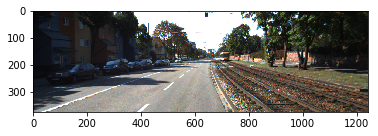

In [263]:
img = mpimg.imread(base_path + '/data_object_image_3/training/image_3/' +current_file+".png")
plt.imshow(img)

In [267]:


rot, tr, sc, image_translate_x, image_translate_y, ang, fliplr = get_augmentation_parameters(False)
# fliplr = True
# tr[0][0] = 10
data_reader_obj = DataReader(list_camera_paths[i_c],
                             list_calib_paths[i_c], 
                             list_label_paths[i_c], 
                             list_lidar_paths[i_c], 
                             rot, sc, tr, ang, image_translate_x, image_translate_y, 
                             get_actual_dims=True, 
                             fliplr=fliplr)

# data_reader_obj.lidar_reader = LidarReader2(list_lidar_paths[i_c], list_calib_paths[i_c], list_camera_paths[i_c], rot, tr, sc, fliplr=fliplr)

camera_image = data_reader_obj.read_image()
lidar_image = data_reader_obj.lidar_reader.read_lidar()
_, label, directions = data_reader_obj.label_reader.read_label()


label2 = get_target(label, directions, anchors=np.array([3.9, 1.6, 1.5]))

In [268]:
print(sc)
print(tr)
print(ang)
print(fliplr)

[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]
[[0]
 [0]
 [0]
 [0]]
0
False


(448, 512)
349.0212022592705 199.20599104660778 26.243912613522273 10.411020566182332 -91.100322
305.9182126852128 201.05155073194123 24.45603640591513 10.28326527087522 -91.67328
273.3492100740009 202.3215536836692 21.71047123259465 9.261261183280393 -94.53806999999999
242.56945946392094 203.52925735600206 27.52105822455743 10.921963305614607 -92.246238
180.94891621299848 208.18353118143284 25.605473759011762 10.60259340175052 -92.819196
147.9346699373521 210.60518888529526 24.903150163734203 10.21933803552441 -93.96511199999999



<Figure size 432x288 with 0 Axes>

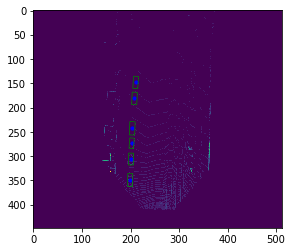

In [269]:

#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[:, :, 0:], 2), 0, 1)
# img = np.fliplr(img)
ax.imshow(img)

print(img.shape)
for i in range(0, len(label)):
    w = label[i][3] 
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
#     x = img.shape[0] - label[i][0]
#     y = img.shape[1] - label[i][1]
    c = 'g'
    if directions[i] >= 1.:
        c = 'b'
    plt.scatter(y, x, s=10, c=c)
    polygon = convert5Pointto8Point(y, x, w, h, (-label[i][6]*57.2958))
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for j in range(4):
        l.append([xs[j], ys[j]])
    rect = patches.Polygon(l,linewidth=0.75,edgecolor='g',facecolor='none')
    ax.add_patch(rect)
    print(x, y, w, h, -label[i][6]*57.2958)

print()


plt.show()


(448, 512)
349.0212022592705 199.20599104660778 26.243912613522273 10.411020566182332 -91.100322
305.9182126852128 201.05155073194123 24.45603640591513 10.28326527087522 -91.67328
273.3492100740009 202.3215536836692 21.71047123259465 9.261261183280393 -94.53806999999999
242.56945946392094 203.52925735600206 27.52105822455743 10.921963305614607 -92.246238
180.94891621299848 208.18353118143284 25.605473759011762 10.60259340175052 -92.819196
147.9346699373521 210.60518888529526 24.903150163734203 10.21933803552441 -93.96511199999999



<Figure size 432x288 with 0 Axes>

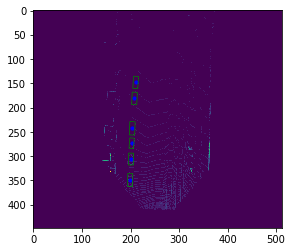

In [270]:

#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[:, :, 0:], 2), 0, 1)
# img = np.fliplr(img)
ax.imshow(img)

print(img.shape)
for i in range(0, len(label)):
    w = label[i][3] 
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
#     x = img.shape[0] - label[i][0]
#     y = img.shape[1] - label[i][1]
    c = 'g'
    if directions[i] >= 1.:
        c = 'b'
    plt.scatter(y, x, s=10, c=c)
    polygon = convert5Pointto8Point(y, x, w, h, (-label[i][6]*57.2958))
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for j in range(4):
        l.append([xs[j], ys[j]])
    rect = patches.Polygon(l,linewidth=0.75,edgecolor='g',facecolor='none')
    ax.add_patch(rect)
    print(x, y, w, h, -label[i][6]*57.2958)

print()


plt.show()


(448, 512)
349.0212022592705 199.20599104660778 26.243912613522273 10.411020566182332 -91.100322
305.9182126852128 201.05155073194123 24.45603640591513 10.28326527087522 -91.67328
273.3492100740009 202.3215536836692 21.71047123259465 9.261261183280393 -94.53806999999999
242.56945946392094 203.52925735600206 27.52105822455743 10.921963305614607 -92.246238
180.94891621299848 208.18353118143284 25.605473759011762 10.60259340175052 -92.819196
147.9346699373521 210.60518888529526 24.903150163734203 10.21933803552441 -93.96511199999999



<Figure size 432x288 with 0 Axes>

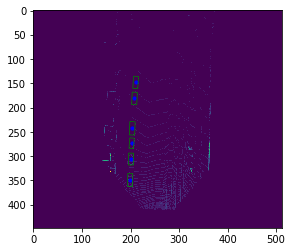

In [271]:

#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[:, :, 0:], 2), 0, 1)
# img = np.fliplr(img)
ax.imshow(img)

print(img.shape)
for i in range(0, len(label)):
    w = label[i][3] 
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
#     x = img.shape[0] - label[i][0]
#     y = img.shape[1] - label[i][1]
    c = 'g'
    if directions[i] >= 1.:
        c = 'b'
    plt.scatter(y, x, s=10, c=c)
    polygon = convert5Pointto8Point(y, x, w, h, (-label[i][6]*57.2958))
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for j in range(4):
        l.append([xs[j], ys[j]])
    rect = patches.Polygon(l,linewidth=0.75,edgecolor='g',facecolor='none')
    ax.add_patch(rect)
    print(x, y, w, h, -label[i][6]*57.2958)

print()


plt.show()


(448, 512)
349.0212022592705 199.20599104660778 26.243912613522273 10.411020566182332 -91.100322
305.9182126852128 201.05155073194123 24.45603640591513 10.28326527087522 -91.67328
273.3492100740009 202.3215536836692 21.71047123259465 9.261261183280393 -94.53806999999999
242.56945946392094 203.52925735600206 27.52105822455743 10.921963305614607 -92.246238
180.94891621299848 208.18353118143284 25.605473759011762 10.60259340175052 -92.819196
147.9346699373521 210.60518888529526 24.903150163734203 10.21933803552441 -93.96511199999999



<Figure size 432x288 with 0 Axes>

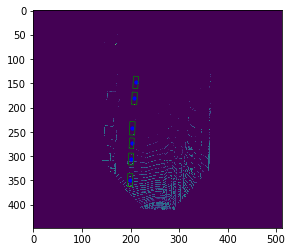

In [272]:

#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(feed_dict[model.train_inputs_lidar][0, :, :, 0:1], 2), 0, 1)
# img = np.fliplr(img)
ax.imshow(img)

print(img.shape)
for i in range(0, len(label)):
    w = label[i][3] 
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
#     x = img.shape[0] - label[i][0]
#     y = img.shape[1] - label[i][1]
    c = 'g'
    if directions[i] >= 1.:
        c = 'b'
    plt.scatter(y, x, s=10, c=c)
    polygon = convert5Pointto8Point(y, x, w, h, (-label[i][6]*57.2958))
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for j in range(4):
        l.append([xs[j], ys[j]])
    rect = patches.Polygon(l,linewidth=0.75,edgecolor='g',facecolor='none')
    ax.add_patch(rect)
    print(x, y, w, h, -label[i][6]*57.2958)

print()


plt.show()


199.20599104660778 27.603218307321598 349.0212022592705
201.05155073194123 27.141934529520974 305.9182126852128
202.3215536836692 27.130331126413093 273.3492100740009
203.52925735600206 26.951864826130578 242.56945946392094
208.18353118143284 26.144172092285427 180.94891621299848
210.60518888529526 25.852536385471232 147.9346699373521



<Figure size 432x288 with 0 Axes>

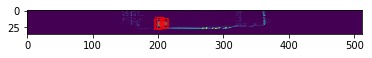

In [273]:
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image.transpose()[:, :, :], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    l = label[i][3]
    w = label[i][4] 
    h = label[i][5]
    x = label[i][0]
    y = label[i][1]
    z = label[i][2]
#     print(y, z)
    plt.scatter(y, z-h/2, s=10)
    a = label[i][6]
#     if a < 0:
#       a = a + 3.14
#     print(h, w, l)
    print(y, z, x)
#     print()
    rect = patches.Rectangle((y-w/2, z-h),w, h, angle= 0,linewidth=0.75,edgecolor='r',facecolor='none')

    ax.add_patch(rect)
    
print()

<Figure size 432x288 with 0 Axes>

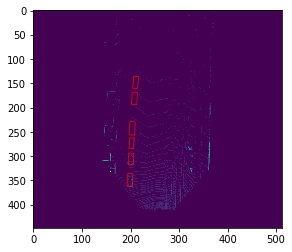

In [274]:
#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[:, :, :], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    w = label[i][3]
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
#     plt.scatter(y, x, s=15)
    a = label[i][6]
#     if a < 0:
#       a = a + 3.14
#     print(w, h, a*57.2958
#     rect = patches.Rectangle((y, x),w, h, angle= a*57.2958,linewidth=0.75,edgecolor='r',facecolor='none')

#     ax.add_patch(rect)
    
    polygon = convert5Pointto8Point(y, x, w, h, -a*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for i in range(4):
        l.append([xs[i], ys[i]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='r',facecolor='none')
    ax.add_patch(rect)



plt.show()


In [275]:
def convert_prediction_into_real_values2(label_tensor, truth_value=None,
            anchors=np.array([3.9, 1.6, 1.5]), 
            input_size=(448, 512), output_size=(112, 128), is_label=False, th=0.5):

    ratio = input_size[0] // output_size[0]
    result = []
    ones_index = np.where(sigmoid(label_tensor[:, :,  -1])>=th)
    if truth_value is not None:
        ones_index = np.where(truth_value[:, :, -1]>=th)
    if len(ones_index) > 0 and len(ones_index[0]) > 0:
        for i in range(0, len(ones_index[0]), 1):
            x = ones_index[0][i]
            y = ones_index[1][i]
            
#             print('x = ', x, "y = ", y)
            
            out = np.copy(label_tensor[ones_index[0][i], ones_index[1][i], :])
            anchor = np.array([x, y, 0., anchors[0], anchors[1], anchors[2]])

            mins = np.array([-0.5, -0.5, 0, 0.7, 0.1, 0.1, -1.1, -1.1])
            maxs = np.array([0.5, 0.5, 1, 1.9, 0.75, 0.91, 1.1, 1.1])
        
            out[:8] = ((out[:8] + 1) / 2) * (maxs - mins) + mins
#             out[:2] = out[:2][::-1]
#             if truth_value is not None:
#                 print('gt = ', truth_value[ones_index[0][i], ones_index[1][i], :3])
#             print('out[:3] = ', out[:3])
            out[3:6] = np.exp(out[3:6])
#             print('exp(out[:3]) = ', out[:3])
    
            out[:3] = out[:3] + anchor[:3]
#             print('out[:3] anch = ', out[:3])
            
            out[:2] = out[:2] * ratio
            out[2] = out[2] * 35
            
#             print('final out[:3] = ', out[:3])
            
            
            
#             out[6] = np.arctan2(out[6], out[7])
                        
            result.append(out)
            
    return np.array(result)

-------------------
6 6
199.20599104660778 349.0212022592705 26.243912613522273 10.411020566182332 -91.100322
201.05155073194123 305.9182126852128 24.45603640591513 10.28326527087522 -91.67328
202.3215536836692 273.3492100740009 21.71047123259465 9.261261183280393 -94.53806999999999
203.52925735600206 242.56945946392094 27.52105822455743 10.921963305614607 -92.246238
208.18353118143284 180.94891621299848 25.605473759011762 10.60259340175052 -92.819196
210.60518888529526 147.9346699373521 24.903150163734203 10.21933803552441 -93.96511199999999

200.97088962132216 306.39430484260015 24.08345198921858 10.576548341160732 -94.04507974805999
199.56743207618166 349.32259239754234 26.333882240411263 10.611302504446549 -86.13290792034
202.31398340295732 274.0074611048981 23.588128419461235 10.25069303640987 -90.19909917306
210.83291900544646 147.32673986359958 27.04306310419224 10.749612317139421 -99.42901710498
208.53224471668858 181.41904334583307 25.45478434582583 10.687342382812451 -96.4204

<Figure size 432x288 with 0 Axes>

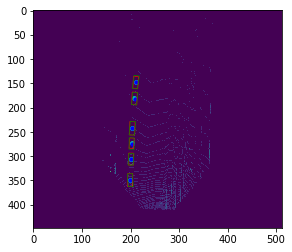

In [276]:
th=0.00001
truth_value = feed_dict[model.y_true][0, :, :, :]
# truth_value = None
converted_points = convert_prediction_into_real_values2(final_output[0, :, :, :], truth_value=truth_value, th=th)
# print(converted_points)
# converted_points = convert_prediction_into_real_values(final_output[0, :, :, :, :], th=th)
points = get_points(converted_points, list_calib_paths[i_c], th=th)
# print(points)
res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])


if True:
        print('-------------------')
        labels, indxes = read_label2(res, base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 0, 0, get_actual_dims=True, from_file=False)
        print(len(labels), len(points))
        if len(labels) != len(points):
            print('not the same')

        points = np.array(points)
        points = points[indxes]
        if len(labels) > 0:
            selected_idx = nms(labels, np.array([points[i][-1] for i in range(len(points))]), max_output_size=100, iou_threshold=0.3)
        else:
            selected_idx = []
#         print('done', len(selected_idx))
        
        if len(selected_idx) > 0:
            points = points[selected_idx]
            res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
        else:
            res=""
 
text_file = open('./' + current_file + '.txt', "wb+")
text_file.write(res.encode())
text_file.close()


data_reader_obj.label_reader = LabelReader('./' + current_file + '.txt', 
                                           list_calib_paths[i_c],
                                           rot, tr, sc, ang, data_reader_obj.calib_reader,
                                        get_actual_dims=True, 
                                        from_file=True, fliplr=fliplr)

points, label_bev, directions = data_reader_obj.read_label()

plt.clf()
fig,ax = plt.subplots(1)

img = np.clip(np.mean(lidar_image[:, :, 18:], 2), 0, 1)
ax.imshow(img)

for i in range(0, len(label)):
    w = label[i][3]
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
   
    plt.scatter(y, x, s=15, c='c')
    a = label[i][6]
   
    print(y, x, w, h, -a*57.2958)

    
    polygon = convert5Pointto8Point(y, x, w, h, -a*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for j in range(4):
        l.append([xs[j], ys[j]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

 
print()

for i in range(0, len(label_bev)):
    w = label_bev[i][3] 
    h = label_bev[i][4] 
    x = label_bev[i][0]
    y = label_bev[i][1]
    print(y, x, w, h, -label_bev[i][6]*57.2958)
    ax.scatter(y, x, s=10, c='b')
    polygon = convert5Pointto8Point(y, x, w, h, -label_bev[i][6]*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for i in range(4):
        l.append([xs[i], ys[i]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='g',facecolor='none')
    ax.add_patch(rect)

print()


plt.show()


In [277]:
278.64734 // 4, 69.0*4, 56*4

(69.0, 276.0, 224)

In [278]:
t3 = feed_dict[model.y_true][0, 56, 69, :3]
t3

array([0., 0., 0.], dtype=float32)

In [279]:
np.sum(t3)

0.0

In [280]:
current_file

'000045'

In [281]:
276.6431893013815 / 4 - 276.6431893013815//4, 278.6925339791378/4 - 278.6925339791378//4

(0.16079732534537072, 0.6731334947844516)

In [282]:
80/512, 80/448, 3.5/35

(0.15625, 0.17857142857142858, 0.1)

In [283]:
t = np.where(feed_dict[model.y_true][0, :, :, -1] > 0)
t

(array([36, 45, 60, 68, 76, 87]), array([52, 52, 50, 50, 50, 49]))

In [284]:
j = 0

In [285]:
for j in range(len(t[0])):
    print(np.mean(final_output[0, t[0][j], t[1][j], :8]))
    print(feed_dict[model.y_true][0, t[0][j], t[1][j], :3])
    print(final_output[0, t[0][j], t[1][j], :3])
    print(feed_dict[model.y_true][0, t[0][j], t[1][j], :3] - final_output[0, t[0][j], t[1][j], :3])
    print('---')

0.5720885
[1.967335  1.3025944 0.4772878]
[1.6633871 1.4164554 0.5324596]
[ 0.30394793 -0.11386096 -0.05517182]
---
0.34458208
[0.4744581  0.09176559 0.4939527 ]
[0.7095321  0.2661233  0.61866444]
[-0.23507398 -0.17435771 -0.12471175]
---
0.6167903
[1.2847297  1.7646286  0.54010653]
[1.1770221 1.9043869 0.659385 ]
[ 0.10770762 -0.13975823 -0.11927849]
---
0.41411456
[0.674605   1.1607769  0.55030465]
[1.0037341  1.1569895  0.61915034]
[-0.3291291   0.0037874  -0.06884569]
---
0.4043234
[0.9591063 0.5257754 0.5509677]
[1.197165   0.4854411  0.54946125]
[-0.23805869  0.04033428  0.00150645]
---
0.48007002
[0.5106011 1.6029955 0.5773268]
[0.6612964 1.7837116 0.611913 ]
[-0.15069532 -0.18071604 -0.03458625]
---


In [286]:
for j in range(len(t[0])):
    print(feed_dict[model.y_true][0, t[0][j], t[1][j], 3:6])
    print(final_output[0, t[0][j], t[1][j], 3:6])
    print(feed_dict[model.y_true][0, t[0][j], t[1][j], 3:6] - final_output[0, t[0][j], t[1][j], 3:6])
    print('---')

[ 0.10162759  0.1384727  -0.27890843]
[ 0.23899417  0.29417798 -0.28639737]
[-0.13736658 -0.15570527  0.00748894]
---
[ 0.1479854   0.25174648 -0.19686979]
[ 0.13813199  0.2762729  -0.18612708]
[ 0.00985341 -0.02452642 -0.01074271]
---
[0.26822984 0.34305653 0.1348538 ]
[ 0.2944448   0.39510787 -0.22274904]
[-0.02621496 -0.05205134  0.35760283]
---
[-0.12704095 -0.16441983 -0.3294727 ]
[ 0.0112239   0.14787231 -0.31366137]
[-0.13826485 -0.31229216 -0.01581132]
---
[0.07144134 0.15764363 0.20441152]
[ 0.04584499  0.24418817 -0.10840814]
[ 0.02559634 -0.08654454  0.31281966]
---
[ 0.18903838  0.19563082 -0.2956484 ]
[ 0.19475625  0.25423515 -0.31481358]
[-0.00571787 -0.05860433  0.01916519]
---


In [287]:
mins = np.array([-0.5, -0.5, 0])
maxs = np.array([0.5, 0.5, 1])
        
t1 = ((feed_dict[model.y_true][0, t[0][j], t[1][j], :3]+ 1) / 2) * (maxs - mins) + mins
t2 =  ((final_output[0, t[0][j], t[1][j], :3]+ 1) / 2) * (maxs - mins) + mins
t1, t2

(array([0.25530052, 0.8014977 , 0.78866339]),
 array([0.33064818, 0.89185572, 0.80595648]))

In [288]:
for i in range(6):
    print((abs(feed_dict[model.y_true][0, t[0][j], t[1][j], i] - final_output[0, t[0][j], t[1][j], i])**2) * 0.5)
    print()
# print(sum((abs(feed_dict[model.y_true][0, t[0][j], t[1][j], :3] - final_output[0,t[0][j], t[1][j], :3])**2) * 0.5))

0.011354540329307383

0.016329143150073833

0.0005981043715781453

1.6347039100139682e-05

0.001717233737086321

0.00018365221695804124



In [289]:
current_file

'000045'

16
9
199.20599104660778 349.0212022592705 26.243912613522273 10.411020566182332 -91.100322
201.05155073194123 305.9182126852128 24.45603640591513 10.28326527087522 -91.67328
202.3215536836692 273.3492100740009 21.71047123259465 9.261261183280393 -94.53806999999999
203.52925735600206 242.56945946392094 27.52105822455743 10.921963305614607 -92.246238
208.18353118143284 180.94891621299848 25.605473759011762 10.60259340175052 -92.819196
210.60518888529526 147.9346699373521 24.903150163734203 10.21933803552441 -93.96511199999999

200.97088962132216 306.39430484260015 24.08345198921858 10.576548341160732 -94.04507974805999
199.56743207618166 349.32259239754234 26.333882240411263 10.611302504446549 -86.13290792034
202.31398340295732 274.0074611048981 23.588128419461235 10.25069303640987 -90.19909917306
210.7899655173423 149.2217748246166 25.8438716208375 10.733257802282633 -92.98415633778001
204.43699962232796 243.08208905959748 26.468510463302078 10.765007871833049 -94.01187110238001
206.882

<Figure size 432x288 with 0 Axes>

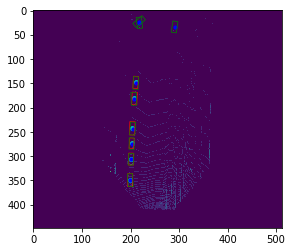

In [290]:
th=0.2
# truth_value = feed_dict[model.y_true][0, :, :, :, :]
truth_value = None
converted_points = convert_prediction_into_real_values2(final_output[0, :, :,  :], truth_value=truth_value, th=th)
# converted_points = convert_prediction_into_real_values(final_output[0, :, :, :, :], th=th)
points = get_points(converted_points, base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', th=th)

res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
# print('res', res)
print(len(points))
if True:
        labels, indxes = read_label2(res, base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 0, 0, get_actual_dims=True, from_file=False)
#         print(len(labels), len(points))
        if len(labels) != len(points):
            print('not the same')

        points = np.array(points)
        points = points[indxes]
        if len(labels) > 0:
            selected_idx = nms(labels, np.array([points[i][-1] for i in range(len(points))]), max_output_size=100, iou_threshold=0.3)
        else:
            selected_idx = []
#         print('done', len(selected_idx))
        
        if len(selected_idx) > 0:
            points = points[selected_idx]
            print(len(points))
            res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
        else:
            res=""
            
   
text_file = open('./' + current_file + '.txt', "wb+")
text_file.write(res.encode())
text_file.close()

# all_data, label_bev, Tr_velo_to_cam, R0_rect, P3, _ = read_label(rot, tr, sc, './'+ current_file + '.txt', 
#                                                   base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 
#                                                   0, 0, get_actual_dims=True)

data_reader_obj.label_reader = LabelReader('./' + current_file + '.txt', 
                                           list_calib_paths[i_c],
                                           rot, tr, sc, ang, data_reader_obj.calib_reader,
                                        get_actual_dims=True, 
                                        from_file=True, fliplr=fliplr)

points, label_bev, directions = data_reader_obj.read_label()

#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[:, :, 18:], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    w = label[i][3]
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
   
    plt.scatter(y, x, s=15, c='c')
    a = label[i][6]
#     if a < 0:
#       a = a + 3.14
    
    print(y, x, w, h, -a*57.2958)
#     print(w, h, a*57.2958
#     rect = patches.Rectangle((y, x),w, h, angle= a*57.2958,linewidth=0.75,edgecolor='r',facecolor='none')

#     ax.add_patch(rect)
    
    polygon = convert5Pointto8Point(y, x, w, h, -a*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for j in range(4):
        l.append([xs[j], ys[j]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
#     if i == 1:
#         break
 
print()

for i in range(0, len(label_bev)):
    w = label_bev[i][3] 
    h = label_bev[i][4] 
    x = label_bev[i][0]
    y = label_bev[i][1]
    print(y, x, w, h, -label_bev[i][6]*57.2958)
    ax.scatter(y, x, s=10, c='b')
    polygon = convert5Pointto8Point(y, x, w, h, -label_bev[i][6]*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for i in range(4):
        l.append([xs[i], ys[i]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='g',facecolor='none')
    ax.add_patch(rect)
#     break

print()


plt.show()


In [234]:
current_file

'000045'

out[:3] =  [0.48289627 0.22878784 0.57940584]
exp(out[:3]) =  [1.6207618 1.2570753 1.7849776]
out[:3] anch =  [12.620762   73.25707     0.78497756]
fginal out[:3] =  [ 50.483047 293.0283    27.474215]
out[:3] =  [0.29294938 0.2622672  0.5868002 ]
exp(out[:3]) =  [1.340375  1.2998738 1.7982253]
out[:3] anch =  [13.340375  73.29987    0.7982253]
fginal out[:3] =  [ 53.3615   293.1995    27.937885]
out[:3] =  [0.34074724 0.5079237  0.6280047 ]
exp(out[:3]) =  [1.4059978 1.6618372 1.873868 ]
out[:3] anch =  [56.406    69.661835  0.873868]
fginal out[:3] =  [225.624   278.64734  30.58538]
3
2
276.6431893013815 226.5721970389598 27.840168210612088 10.091696514351105 90.527364

278.6473374483395 225.62397287652053 24.814301332961698 9.912644701148855 -86.00143697765999
293.19949105200067 53.36146423920968 21.561427700385494 10.263973512336268 73.58254367976001



<Figure size 432x288 with 0 Axes>

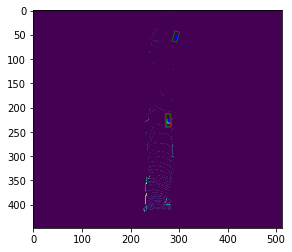

In [295]:
th=0.1
# truth_value = feed_dict[model.y_true][0, :, :, :, :]
truth_value = None
converted_points = convert_prediction_into_real_values(final_output[0, :, :,  :], truth_value=truth_value, th=th)
# converted_points = convert_prediction_into_real_values(final_output[0, :, :, :, :], th=th)
points = get_points(converted_points, base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', th=th)

res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
# print('res', res)
print(len(points))
if True:
        labels, indxes = read_label2(res, base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 0, 0, get_actual_dims=True, from_file=False)
#         print(len(labels), len(points))
        if len(labels) != len(points):
            print('not the same')

        points = np.array(points)
        points = points[indxes]
        if len(labels) > 0:
            selected_idx = nms(labels, np.array([points[i][-1] for i in range(len(points))]), max_output_size=100, iou_threshold=0.3)
        else:
            selected_idx = []
#         print('done', len(selected_idx))
        
        if len(selected_idx) > 0:
            points = points[selected_idx]
            print(len(points))
            res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
        else:
            res=""
            
   
text_file = open('./' + current_file + '.txt', "wb+")
text_file.write(res.encode())
text_file.close()

all_data, label_bev, Tr_velo_to_cam, R0_rect, P3, _ = read_label(rot, tr, sc, './'+ current_file + '.txt', 
                                                  base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 
                                                  0, 0, get_actual_dims=True)

#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[:, :, 18:], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    w = label[i][3]
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
   
    plt.scatter(y, x, s=15, c='c')
    a = label[i][6]
#     if a < 0:
#       a = a + 3.14
    
    print(y, x, w, h, -a*57.2958)
#     print(w, h, a*57.2958
#     rect = patches.Rectangle((y, x),w, h, angle= a*57.2958,linewidth=0.75,edgecolor='r',facecolor='none')

#     ax.add_patch(rect)
    
    polygon = convert5Pointto8Point(y, x, w, h, -a*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for j in range(4):
        l.append([xs[j], ys[j]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
#     if i == 1:
#         break
 
print()

for i in range(0, len(label_bev)):
    w = label_bev[i][3] 
    h = label_bev[i][4] 
    x = label_bev[i][0]
    y = label_bev[i][1]
    print(y, x, w, h, -label_bev[i][6]*57.2958)
    ax.scatter(y, x, s=10, c='b')
    polygon = convert5Pointto8Point(y, x, w, h, -label_bev[i][6]*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for i in range(4):
        l.append([xs[i], ys[i]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='g',facecolor='none')
    ax.add_patch(rect)
#     break

print()


plt.show()


In [175]:
226.5721970389598 // 4 - 226.5721970389598/4, 225.08346074265836//4 - 225.08346074265836/4

(-0.6430492597399535, -0.27086518566459006)

262.7711192182209 27.175046172913504 361.7245071264439

263.201262993302 28.231951994629 361.7796858190811
249.401993232204 26.07350247649823 437.4410390667927


<Figure size 432x288 with 0 Axes>

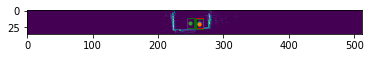

In [176]:
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image.transpose()[:, :, :], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    l = label[i][3]
    w = label[i][4] 
    h = label[i][5]
    x = label[i][0]
    y = label[i][1]
    z = label[i][2]
#     print(y, z)
    plt.scatter(y, z-h/2, s=10)
    a = label[i][6]
#     if a < 0:
#       a = a + 3.14
#     print(h, w, l)
    print(y, z, x)
#     print()
    rect = patches.Rectangle((y-w/2, z-h),w, h, angle= 0,linewidth=0.75,edgecolor='r',facecolor='none')

    ax.add_patch(rect)
    
print()
for i in range(0, len(label_bev)):
    l = label_bev[i][3]
    w = label_bev[i][4] 
    h = label_bev[i][5]
    x = label_bev[i][0]
    y = label_bev[i][1]
    z = label_bev[i][2]
#     print(y, z)
    plt.scatter(y, z-h/2, s=10)
    a = label_bev[i][6]
#     if a < 0:
#       a = a + 3.14
#     print(h, w, l)
    print(y, z, x)
#     print()
    rect = patches.Rectangle((y-w/2, z-h),w, h, angle= 0,linewidth=0.75,edgecolor='g',facecolor='none')

    ax.add_patch(rect)
    
plt.show()


### Visualization

In [187]:
i = 2
j = 5
np.mean(final_output[0, :, :, j])

0.35814658

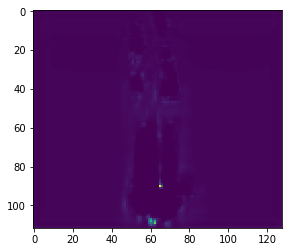

In [177]:
plt.imshow(sigmoid(final_output[0, :, :, -1]))

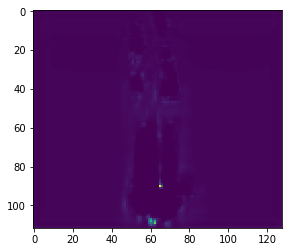

In [178]:
plt.imshow(sigmoid(final_output[0, :, :, -1]))

In [46]:
debug_layers.keys()

dict_keys(['fpn_lidar2_output_post_conv_1_1', 'fpn_lidar2_output_post_conv_1_0', 'fpn_lidar1_output_post_conv_1_1', 'final_layer', 'fpn_lidar1_output_post_conv_1_0'])

In [47]:
debug_layers['fpn_lidar1_output_post_conv_1_1'].shape

(1, 112, 128, 128)

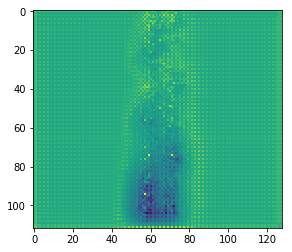

In [40]:
i = 50
plt.imshow(debug_layers['fpn_lidar1_output_post_conv_1_0'][0, :, :, i])

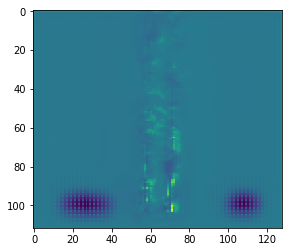

In [65]:
i = 50
plt.imshow(debug_layers['fpn_lidar1_output_post_conv_1_0'][0, :, :, i])

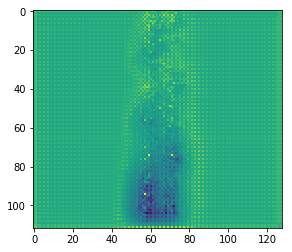

In [41]:
i = 50
plt.imshow(debug_layers['fpn_lidar1_output_post_conv_1_0'][0, :, :, i])

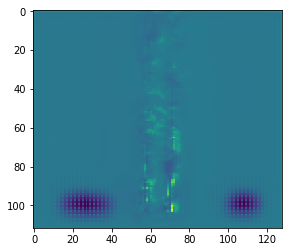

In [66]:
i = 50
plt.imshow(debug_layers['fpn_lidar1_output_post_conv_1_0'][0, :, :, i])

In [50]:
cnn_lidar_resgroups[0].shape

(1, 224, 256, 64)

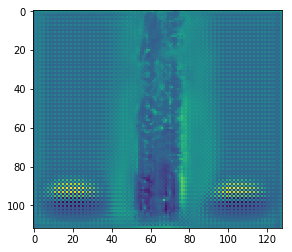

In [51]:
i = 3
j = 33
plt.imshow(cnn_lidar_resgroups[i][0, :, :, j])

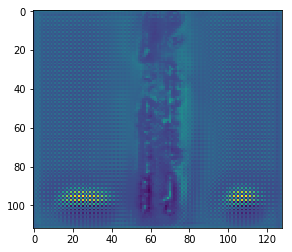

In [67]:
i = 3
j = 33
plt.imshow(cnn_lidar_resgroups[i][0, :, :, j])